In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
from scipy.stats import linregress

In [139]:
# necessario creare una cartella dati fuori da questa
magistrale= pd.DataFrame(pd.read_excel("../dati/iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("../dati/iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("../dati/piani_informatica.xls"))

In [140]:
# verifico di avere un campione sufficiente all'analisi

Z = 1.96  # Livello di confidenza del 95%
sigma = 10  # Deviazione standard stimata
E = 2  # Margine di errore desiderato

# Calcolo della dimensione del campione
n = (Z * sigma / E) ** 2
n = math.ceil(n)  # Arrotonda per eccesso al numero intero più vicino

print(f"Dimensione del campione necessaria: {n}")

Dimensione del campione necessaria: 97


In [141]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [142]:
# join triennale
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO', 'ANAC_USCITA','DATA_LAUREA','SITUAZIONE_FINALE','VOTO_LAUREA']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [143]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# rimozione idoneità
pt = pt[(pt['DECODIFICA_INS'] != 'CULTURA AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'ELEMENTI DI CULTURA AZIENDALE, PROFESSIONALE, SOCIALE E GIURIDICA') &
        (pt['DECODIFICA_INS'] != 'GESTIONE AZIENDALE') &
        (pt['DECODIFICA_INS'] != 'LINGUA INGLESE 1') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE') &
        (pt['DECODIFICA_INS'] != 'PERFEZIONAMENTO DELLA LINGUA INGLESE  ')]

# elimino i voti maggiori di 31
pt = pt[(pt['VOTO'] != 36) & # 36: dispensato, credo si rifersica a crediti acquistiti grazie ad un passaggio di carriera
        (pt['VOTO'] != 40) & # 40: tirocinio effettuato
        (pt['VOTO'] != 41) & # 41: tirocinio approvato
        (pt['VOTO'] != 46) & # 46: ofa non superati
        (pt['VOTO'] != 45) & # 45: superato (laurea, ofa, ...)
        (pt['VOTO'] != 96)]  # 96: registrato per errore

# 31: lode
pt['VOTO'] = pt['VOTO'].replace({35: 0}) # 35: ritirato
pt['VOTO'] = pt['VOTO'].replace({44: 17}) # 44: respinto


A cosa si riferiscono i voti maggiori di 32?

In [146]:
# creo un db che unisce insegnamenti vecchi e nuovi

pt_vecchi = pt.copy()

pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'BASI DI DATI 2': 'BASI DI DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPLEMENTI DI ALGORITMI E STRUTTURE DATI (8 CFU)': 'ALGORITMI E STRUTTURE DATI'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'COMPUTAZIONE QUANTISTICA': 'FONDAMENTI DI COMPUTAZIONE QUANTISTICA'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'ELEMENTI DI MATEMATICA E LOGICA': 'ALGEBRA E LOGICA PER INFORMATICA'})
# pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"FONDAMENTI DELL'INFORMATICA": ''})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'GEOMETRIA': 'ALGEBRA LINEARE E ANALISI NUMERICA'})    # ???
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'INGEGNERIA DEL SOFTWARE (6 CFU)': 'FONDAMENTI DI INGEGNERIA DEL SOFTWARE'})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({"SISTEMI DI ELABORAZIONE DELL'INFORMAZIONE 1":"SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})
pt_vecchi['DECODIFICA_INS'] = pt_vecchi['DECODIFICA_INS'].replace({'SISTEMI DI ELABORAZIONE E DI TRASMISSIONE': "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE"})


# Non conosco
# FONDAMENTI DELL'INFORMATICA
# SISTEMI ERP


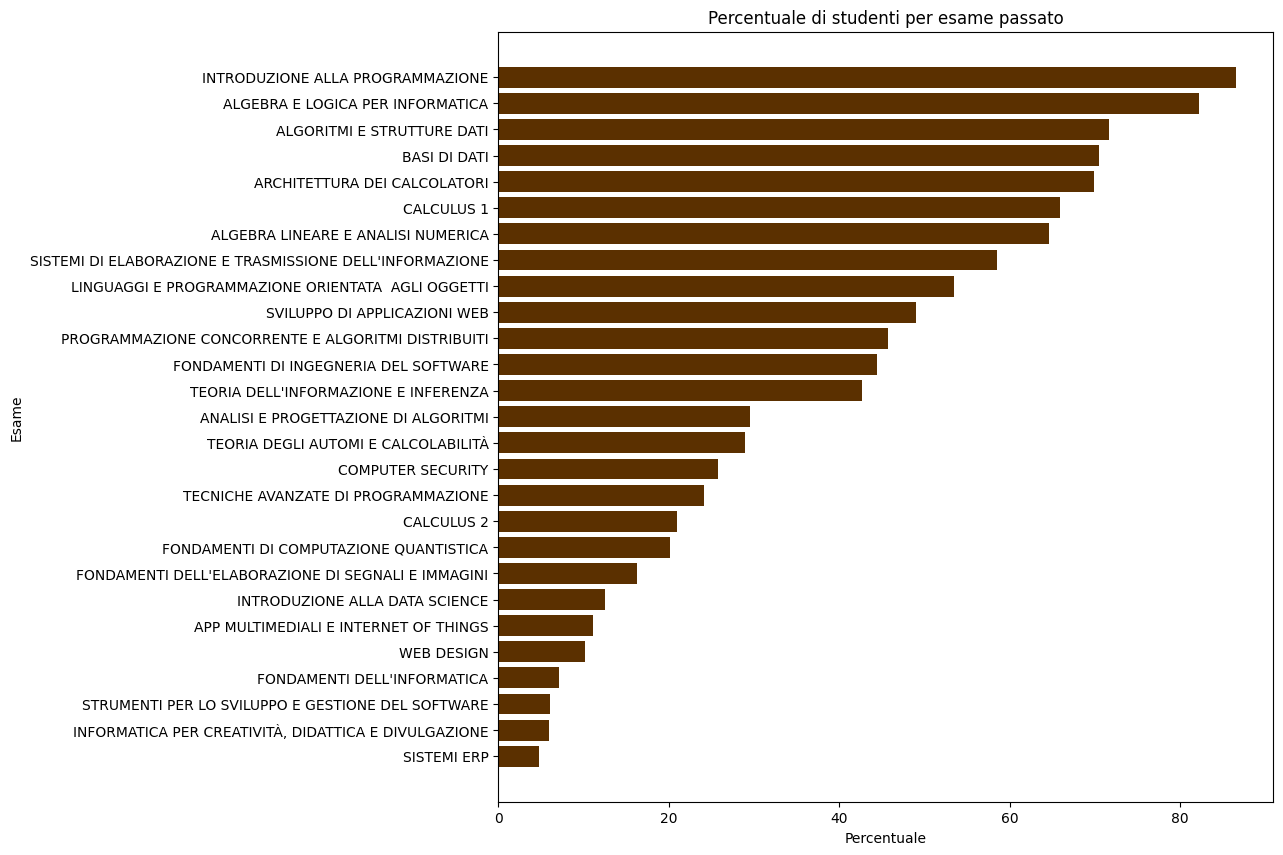

In [147]:
# percentuale studenti per esame, su quelli nel database
perc =(pt_vecchi.groupby('DECODIFICA_INS').size() / pt_vecchi['PROGRESSIVO'].nunique()) *100

perc_sorted = perc.sort_values()
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_sorted.index, perc_sorted, color='#5B3000')
plt.xlabel('Percentuale')
plt.ylabel('Esame')
plt.title('Percentuale di studenti per esame passato')
plt.show()

In [148]:

primo_anno = pt[(pt['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (pt['DECODIFICA_INS'] == "ALGORITMI E STRUTTURE DATI") |
                 (pt['DECODIFICA_INS'] == "ARCHITETTURA DEI CALCOLATORI") |
                 (pt['DECODIFICA_INS'] == "CALCULUS 1") |
                 (pt['DECODIFICA_INS'] == "INTRODUZIONE ALLA PROGRAMMAZIONE")]


secondo_anno = pt[(pt['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (pt['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (pt['DECODIFICA_INS'] == "BASI DI DATI") |
                 (pt['DECODIFICA_INS'] == "LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI") |
                 (pt['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (pt['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA")]

terzo_anno = pt[(pt['DECODIFICA_INS'] == "COMPUTER SECURITY") | # per tutti
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE") |
                 (pt['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (pt['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB")]

propedeutico = pt[(pt['DECODIFICA_INS'] == "CALCULUS 2") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA") |
                 (pt['DECODIFICA_INS'] == "TEORIA DEGLI AUTOMI E CALCOLABILITÀ")]

tecnologico = pt[(pt['DECODIFICA_INS'] == "TECNICHE AVANZATE DI PROGRAMMAZIONE")]

scelta = pt[(pt['DECODIFICA_INS'] == "APP MULTIMEDIALI E INTERNET OF THINGS") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DELL'ELABORAZIONE DI SEGNALI E IMMAGINI")
                 (pt['DECODIFICA_INS'] == "INFORMATICA PER CREATIVITÀ, DIDATTICA E DIVULGAZIONE") |
                 (pt['DECODIFICA_INS'] == "INTRODUZIONE ALLA DATA SCIENCE") |
                 (pt['DECODIFICA_INS'] == "STRUMENTI PER LO SVILUPPO E GESTIONE DEL SOFTWARE") |
                 (pt['DECODIFICA_INS'] == "WEB DESIGN")]
            

TypeError: 'Series' object is not callable

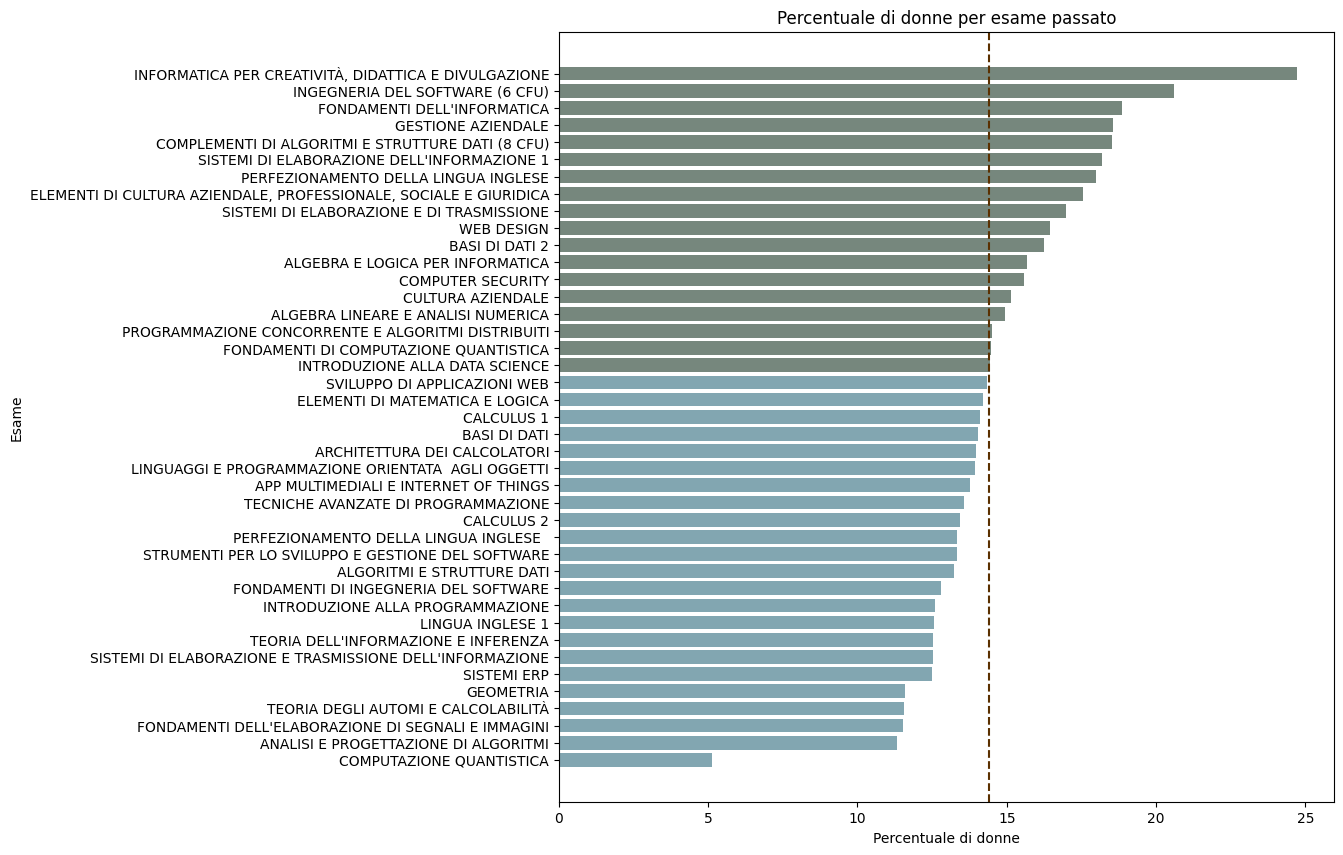

In [ ]:
# visualizzazione percentuale di donne sul numero totale, di persone che hanno superato l'esame
perc_donne = ((pt[pt['GENERE'] == 'F'].groupby('DECODIFICA_INS').size() / pt.groupby('DECODIFICA_INS').size()) * 100)#.astype(int)

perc_donne_sorted = perc_donne.sort_values()
colors = ['#82A6B1' if val < 14.4 else '#76877D' for val in perc_donne_sorted]
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_donne_sorted.index, perc_donne_sorted, color=colors)
plt.axvline(x=14.4, color='#5B3000', linestyle='--')
plt.xlabel('Percentuale di donne')
plt.ylabel('Esame')
plt.title('Percentuale di donne per esame passato')
plt.show()